# GIS Programming and Databases
## Assignment 3

NAME: Grey Harris
ID: 97774899




## Imports

In [53]:
import xarray as xr
import datetime
import numpy as np # you can use numpy functions with xarray objects
import salem # this will help with plotting/projection 
import cartopy.crs as ccrs # an alternative way to handle plotting/projection yourself
import matplotlib.pyplot as plt
from math import ceil
import fwi_nz as fwi_calc  # The fwi calculator, make sure to have fwi_nz.py in the same folder as this notebook
import numpy as np # you can use numpy functions with xarray objects
import glob # a library to handle path/folder/file related issues
from dask.diagnostics import ProgressBar
import geocoder
import time
import geopandas
import shapely
import envlib_helper as envlib
from tethysts import Tethys
import rioxarray
from shapely.geometry import mapping
from shapely import wkt
from dateutil.relativedelta import relativedelta

In [2]:
from pathlib import Path
user_home = str(Path.home())
from dask.distributed import Client
client = Client(n_workers=20, threads_per_worker=1, memory_limit='6GB',local_directory=user_home)
client
tasks = [False, True]

distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-09ayeqcf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-92l96e_1', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-x6ad4pph', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-b1hbtzgx', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-9lscg1dw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-j31sjm_e', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-1yj58g5t', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask

In [29]:
teth = Tethys()

In [30]:
envlib.get_all_dataset_information(Tethys())

method  \
feature    parameter             owner                                            
atmosphere air_ventilation_index NZ Open Modelling Consortium        simulation   
                                 NZ Open Modelling Consortium        simulation   
           barometric_pressure   ECMWF                               simulation   
                                 MET Norway                            forecast   
                                 MetService                          simulation   
...                                                                         ...   
waterway   surface_runoff        ECMWF                               simulation   
           temperature           Environment Canterbury        sensor_recording   
           water_use             Environment Southland               simulation   
                                 Environment Southland               simulation   
                                 Environment Southland               simulation   

                                                                                              product_code  \
feature    parameter             owner                                                                       
atmosphere air_ventilation_index NZ Open Modelling Consortium  UC WRF NZ South Island North Canterbury 1km   
                                 NZ Open Modelling Consortium     UC WRF NZ South Island Central Otago 1km   
           barometric_pressure   ECMWF                                                reanalysis-era5-land   
                                 MET Norway                                          YR_ECMWF_9km_forecast   
                                 MetService                                           Moana backbone model   
...                                                                                                    ...   
waterway   surface_runoff        ECMWF                                                reanalysis-era5-land   
           temperature           Environment Canterbury                            quality_controlled_data   
           water_use             Environment Southland                           stream depletion method 1   
                                 Environment Southland                             WAP allocation method 1   
                                 Environment Southland                                 estimation method 1   

                                                              aggregation_statistic  \
feature    parameter             owner                                                
atmosphere air_ventilation_index NZ Open Modelling Consortium         instantaneous   
                                 NZ Open Modelling Consortium         instantaneous   
           barometric_pressure   ECMWF                                instantaneous   
                                 MET Norway                                    mean   
                                 MetService                           instantaneous   
...                                                                             ...   
waterway   surface_runoff        ECMWF                                   cumulative   
           temperature           Environment Canterbury                        mean   
           water_use             Environment Southland                         mean   
                                 Environment Southland                   cumulative   
                                 Environment Southland                   cumulative   

                                                              frequency_interval  \
feature    parameter             owner                                             
atmosphere air_ventilation_index NZ Open Modelling Consortium                  H   
                                 NZ Open Modelling Consortium                  H   
           barometric_pressure   ECMWF                                         H   
          

# Task 1
### Objective: To understand how the modelled FWI compares to observations from AWSs leading to a real event of the Port Hills Fire that started on the afternoon of 13th of February 2017. Remember the dataset uses the UTC time zone and units of temperature for FWI calculations should in in Celsius.

# a) 
For this subtask use the nearest FENZ weather station to Early Valley Road (EVR),
Christchurch. From the selected FENZ AWS construct the time series of FWI based on
three different starting date scenarios (1 week prior to the fire event, 1 month prior,
and 2 month prior). Avoid starting on a day when precipitation was occurring so adjust
accordingly. Please revisit our Lab 07 course recording if you forget how to access the
FENZ weather station data.

In [31]:
station_data = envlib.get_data_from_lat_lon(teth, "FENZ", "sensor_recording", "raw_data", -43.722, 172.596,squeeze_dims=True)
station_data

<xarray.Dataset>
Dimensions:                   (time: 198348)
Coordinates:
  * time                      (time) datetime64[ns] 1999-08-13T23:00:00 ... 2...
    geometry                  <U42 '01010000007B14AE47E1926540C7681D554DDC45C0'
    height                    int8 2
Data variables:
    station_id                object '1dd0e5e15552fce719028dbd'
    externalId                object 'CLIDB_39788'
    name                      object 'Motukarara'
    ref                       object 'motukarara'
    wind_direction            (time) float32 nan 67.5 67.5 ... 58.8 56.0 54.9
    lat                       float64 -43.72
    lon                       float64 172.6
    temperature               (time) float32 8.0 8.0 8.1 8.0 ... 18.6 18.9 19.5
    precipitation             (time) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wind_speed                (time) float32 3.5 4.05 4.45 ... 11.02 11.89 11.45
    relative_humidity         (time) float32 82.5 79.5 83.0 ... 71.2 69.7 65.4
    volumetric_water_content  (time) float32 nan nan nan nan ... 7.0 7.0 7.0 7.0
Attributes:
    result_type:     time_series
    title:           mean wind_direction in deg of the atmosphere by a sensor...
    institution:     FENZ
    license:         https://creativecommons.org/licenses/by/4.0/
    source:          sensor_recording
    system_version:  4
    version_date:    2022-03-23T00:00:00

In [32]:
def subtract_m(date,x):
    """subtracts x months from date"""
    date_f = '%Y-%m-%d'
    date_x = datetime.datetime.strptime("2017-02-13",date_f)
    past_date = date_x - relativedelta(months=x)
    return past_date.strftime(date_f)

# Test case
#x = subtract_m("2017-02-13",2)
#x

In [33]:
#having a look at precipitation in previous month
station_data.sel(time=slice(subtract_m("2017-02-13",1),"2017-02-13")).precipitation

<xarray.DataArray 'precipitation' (time: 768)>
array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8,
       1.6, 1.2, 0.2, 0.8, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2,
       1.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0.2, 0. , 0. , 0. , 3. , 0.6, 0.6, 0. , 0. , 0. , 0.2,
       1.4, 0.8, 0.2, 0.2, 0.4, 3.8, 2.8, 9.6, 6. , 2.8, 2. , 1.2, 0.4,
       0. , 0.2, 0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0.6,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
...
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. ], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-13 ... 2017-02-13T23:00:00
    geometry  <U42 '01010000007B14AE47E1926540C7681D554DDC45C0'
    height    int8 2
Attributes:
    feature:                atmosphere
    parameter:              precipitation
    method:                 sensor_recording
    product_code:           raw_data
    owner:                  FENZ
    aggregation_statistic:  cumulative
    frequency_interval:     1H
    utc_offset:             0H
    dataset_id:             c5f55d97e71e7cd73295ad7f
    units:                  mm
    license:                https://creativecommons.org/licenses/by/4.0/
    attribution:            Data licenced by FENZ
    result_type:            time_series
    precision:              0.1
    block_length:           0.0
    time_interval:          7300
    standard_name:          precipitation_amount

## looking at one week before

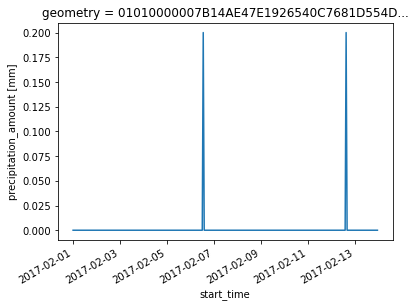

In [75]:
pltd = station_data.sel(time=slice("2017-02-01","2017-02-13")).precipitation.plot()
pltd

In [34]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_1_week = fwi_calc.FWI_combined_calc(
    station_data.temperature,
    station_data.relative_humidity,
    station_data.wind_speed,
    station_data.precipitation,
    start_date="2017-02-06",  ### one week ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=False,
    complevel=1
)

start date 2017-02-06
end data 2017-02-13
RAIN matrix size: (8,)
RH matrix size:  (8,)
T matrix size:  (8,)
wind matrix size:  (8,)
CPU times: user 138 ms, sys: 9.27 ms, total: 147 ms
Wall time: 153 ms


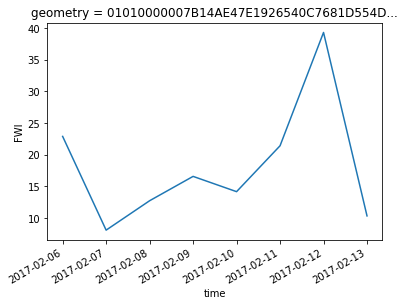

In [35]:
fwi_1_week.plot()

## looking at one month before

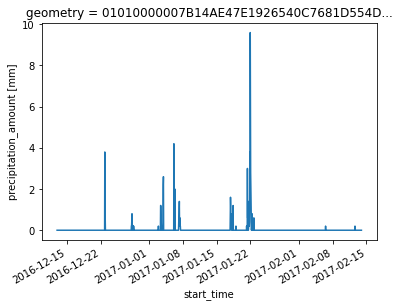

In [36]:
# looking at precipitaton in previous month
plt1 = station_data.sel(time=slice(subtract_m("2017-02-13",2),"2017-02-13")).precipitation.plot()
plt1

In [37]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_1_month = fwi_calc.FWI_combined_calc(
    station_data.temperature,
    station_data.relative_humidity,
    station_data.wind_speed,
    station_data.precipitation,
    start_date="2017-01-15",  ### one month ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=False,
    complevel=1
)

start date 2017-01-15
end data 2017-02-13
RAIN matrix size: (30,)
RH matrix size:  (30,)
T matrix size:  (30,)
wind matrix size:  (30,)
CPU times: user 310 ms, sys: 3.76 ms, total: 313 ms
Wall time: 312 ms


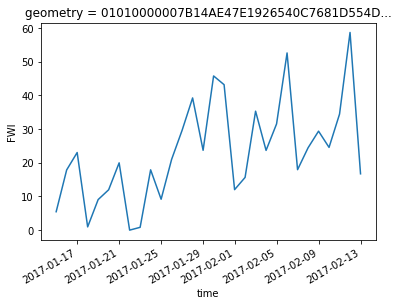

In [38]:
fwi_1_month.plot()

## looking at two months before

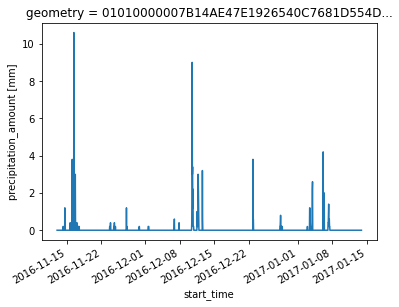

In [39]:
# have a look at precipetstion each side of 2 months prior to fire
plt2 = station_data.sel(time=slice(subtract_m("2017-02-13",3),subtract_m("2017-02-13",1))).precipitation.plot()
# plt.set_title("Precipitation between 2017-02-13 and 2017-02-13")
# plt.show()

In [40]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_2_month = fwi_calc.FWI_combined_calc(
    station_data.temperature,
    station_data.relative_humidity,
    station_data.wind_speed,
    station_data.precipitation,
    start_date=subtract_m("2017-02-13",2),  ### two months ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=False,
    complevel=1
)

start date 2016-12-13
end data 2017-02-13
RAIN matrix size: (63,)
RH matrix size:  (63,)
T matrix size:  (63,)
wind matrix size:  (63,)
CPU times: user 570 ms, sys: 0 ns, total: 570 ms
Wall time: 569 ms


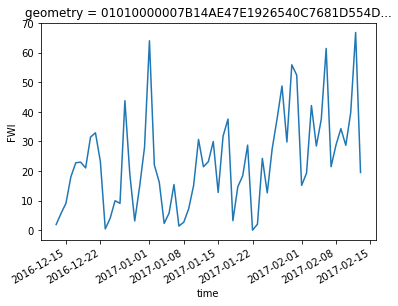

In [41]:
fwi_2_month.plot()

# b) 
Repeat task 1a but with data from the nearest WRF grid point to EVR.

In [42]:
def to_celcius(df):
    """convert kelvin to celcius"""
    return df.T - 273.15

def site_preprocessor(ds):
    """selects the nearest site with lat lon"""
    lat, lon = -43.730475, 172.584934  # Motukarara from google maps
    return ds.sel(lat=lat, lon=lon, method="nearest").isel(height=0)
    

def site_preprocessor_rain(ds):
    """selects the nearest site with lat lon, works for rainnc"""
    lat, lon = -43.730475, 172.584934  # Motukarara from google maps
    return ds.sel(lat=lat, lon=lon, method="nearest")
    

def dataloader(dataname, site, chunks={"time":24,"height":1}, rain=False):
    """loads data from files and pre processes them with chink sizes advised by teaching staff"""
    daterange = ["20161201", "20170101", "20170201"]
    files = ["/srv/MetService_WRF/storage/data/moana/processed/" + dataname + date + "000000.nc" for date in daterange]
    if rain: #if rain data height is already dropped
        return xr.open_mfdataset(files, chunks=chunks, preprocess=site, parallel=True)
    return xr.open_mfdataset(files, chunks=chunks, preprocess=site, parallel=True).drop("height")

In [43]:
lat, lon = -43.730475, 172.584934  # Motukarara from google maps
rh, t, u, v, rain = "RH_", "T_", "U_", "V_", "RAINNC_"
#ds_rh = dataloader(rh, site_preprocessor) #testing first

In [44]:
ds_rh = dataloader(rh, site_preprocessor)
ds_t = dataloader(t, site_preprocessor)
ds_u = dataloader(u, site_preprocessor)
ds_v = dataloader(v, site_preprocessor)
ds_rain = dataloader(rain, site_preprocessor_rain, chunks={"time":24}, rain=True)

### 1b) one week

In [45]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data_WRF_1w = fwi_calc.FWI_combined_calc(
    to_celcius(ds_t),
    ds_rh.RH,
    fwi_calc.wind_speed_from_component(ds_u.U, ds_v.V),
    ds_rain.RAINNC,
    start_date="2017-02-06",  ### two months ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=True,
    save_loc="q1b_1_week",
    complevel=1
)

start date 2017-02-06
end data 2017-02-13
RAIN matrix size: (8,)
RH matrix size:  (8,)
T matrix size:  (8,)
wind matrix size:  (8,)
CPU times: user 962 ms, sys: 695 ms, total: 1.66 s
Wall time: 11.9 s


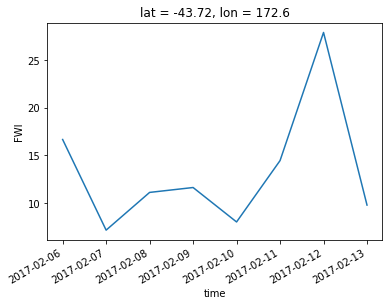

In [46]:
fwi_data_WRF_1w.plot()

### 1b) one month

In [47]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data_WRF_1m = fwi_calc.FWI_combined_calc(
    to_celcius(ds_t),
    ds_rh.RH,
    fwi_calc.wind_speed_from_component(ds_u.U, ds_v.V),
    ds_rain.RAINNC,
    start_date="2017-01-15",  ### one month ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=True,
    save_loc="q1b_1_month",
    complevel=1
)

start date 2017-01-15
end data 2017-02-13
RAIN matrix size: (30,)
RH matrix size:  (30,)
T matrix size:  (30,)
wind matrix size:  (30,)
CPU times: user 3.46 s, sys: 2.52 s, total: 5.98 s
Wall time: 18.2 s


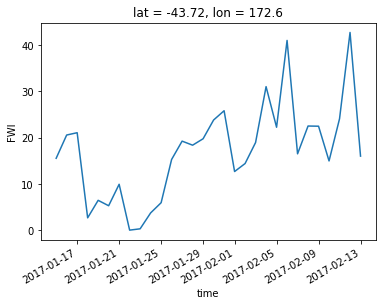

In [48]:
fwi_data_WRF_1m.plot()

### 1b) two months

In [49]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data = fwi_calc.FWI_combined_calc(
    to_celcius(ds_t),
    ds_rh.RH,
    fwi_calc.wind_speed_from_component(ds_u.U, ds_v.V),
    ds_rain.RAINNC,
    start_date="2016-12-13",  ### two months ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=True,
    save_loc="q1b_2_months",
    complevel=1
)

start date 2016-12-13
end data 2017-02-13
RAIN matrix size: (63,)
RH matrix size:  (63,)
T matrix size:  (63,)
wind matrix size:  (63,)
18
Current Time = 19:57:24 . Saving Fire Weather Indices (2016) ...
Current Time = 19:57:48 . File saved. Continue next year ...
CPU times: user 12.5 s, sys: 9.39 s, total: 21.9 s
Wall time: 47.6 s


start date 2016-12-13
end data 2017-02-13
RAIN matrix size: (63,)
RH matrix size:  (63,)
T matrix size:  (63,)
wind matrix size:  (63,)
18
Current Time = 20:03:07 . Saving Fire Weather Indices (2016) ...
Current Time = 20:03:10 . File saved. Continue next year ...
CPU times: user 12.7 s, sys: 9.21 s, total: 21.9 s
Wall time: 17.5 s


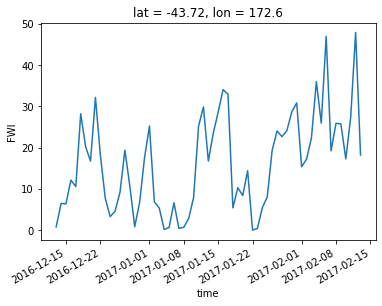

In [55]:
%%time
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data_WRF = fwi_calc.FWI_combined_calc(
    to_celcius(ds_t),
    ds_rh.RH,
    fwi_calc.wind_speed_from_component(ds_u.U, ds_v.V),
    ds_rain.RAINNC,
    start_date="2016-12-13",  ### two months ensuring not on day after precipetation
    end_date = "2017-02-13",
    ws_unit="m/s",
    save_fwi=True,
    save_loc="q1b_2_months2",
    complevel=1
)
fwi_data_WRF.plot()

# c) 
#### Compare and discuss the FWI from task 1a and 1b. Give possible explanations to the differences and use data/figures to support.

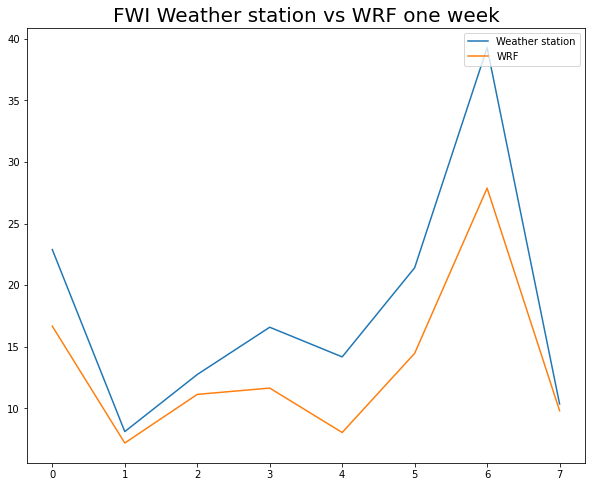

In [60]:
f, ax = plt.subplots(figsize=(10, 8))
fs = 20
plt.plot(fwi_1_week,label="Weather station")
plt.plot(fwi_data_WRF_1w,label="WRF")
plt.title(label="FWI Weather station vs WRF one week",fontsize=fs)
plt.legend(loc="upper right")

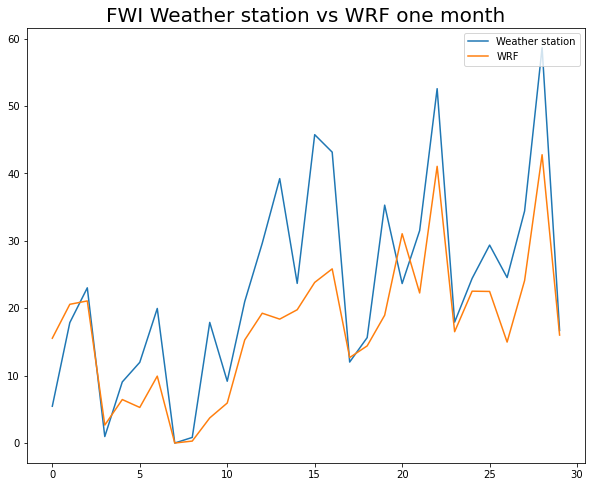

In [59]:
f, ax = plt.subplots(figsize=(10, 8))
fs = 20
plt.plot(fwi_1_month,label="Weather station")
plt.plot(fwi_data_WRF_1m,label="WRF")
plt.title(label="FWI Weather station vs WRF one month",fontsize=fs)
plt.legend(loc="upper right")

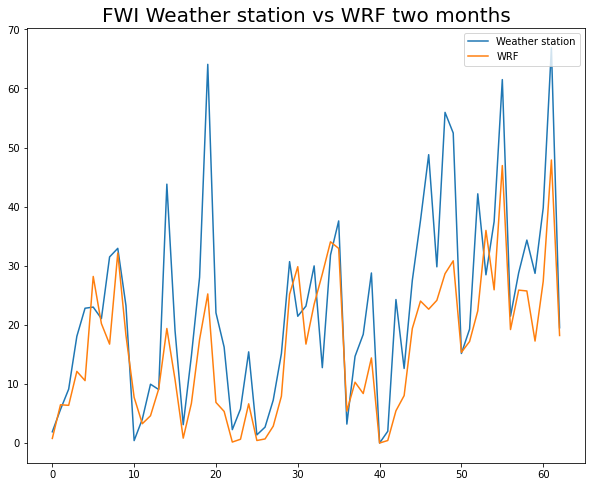

In [58]:
f, ax = plt.subplots(figsize=(10, 8))
fs = 20
plt.plot(fwi_2_month,label="Weather station")
plt.plot(fwi_data_WRF,label="WRF")
plt.title(label="FWI Weather station vs WRF two months",fontsize=fs)
plt.legend(loc="upper right")

The station data is real recordings from an exact point on the map. The WRF is sumulated data around 4km areas. 

The station data in blue seems to exhibit more extremes in fwi value than the simulated data does. 

This may be due to true readings at a single point for wind speed and temp being higher than the larger area which is an average of that area.

To prove this is the case the local topography could be useful as the single point site might be on a hill where it is exposed to more sunlight and wind than the arveraged area is. 

# Task 2
### Objective: To understand how the modelled FWI compares to observations from AWSs leading to a real event of the Port Hills Fire that started on the afternoon of 13th of February 2017. Remember the dataset uses the UTC time zone and units of temperature for FWI calculations should in in Celsius.

# 2a) 
Where are the regions in New Zealand that exhibit the highest occurrence of extreme
fire weather conditions? Explain the potential reasons for the spatial heterogeneity.
Hint: Use the minimum extreme FWI threshold of 31 (inclusive) to calculate the number
of days exceeding this threshold for each pixel in the WRF data. You will need to
produce one map at the end of this subtask.

For assignment 3 task 2a please only use 5 years of data


In [1]:
import itertools

def to_celcius(df):
    """convert kelvin to celcius"""
    return df.T - 273.15


def site_preprocessor_5y(ds):
    """selects the nearest site with lat lon"""
    return ds.isel(height=0)


def dataloader(dataname, site, chunks={"time":24,"height":1}, rain=False):
    """loads five years data and pre processes them into chunks"""
    five_years = ["2016", "2017", "2018", "2019", "2020"]
    files = [sorted(glob.glob(f"/mnt/data/MetService_WRF/{dataname}{year}*", recursive=False)) for year in five_years]
    merged = list(itertools.chain(*files))
    if rain: #if rain data height is already dropped
        return xr.open_mfdataset(merged, chunks=chunks, parallel=True)
    return xr.open_mfdataset(merged, chunks=chunks, preprocess=site, parallel=True).drop("height")

In [2]:
rh, t, u, v, rain = "RH_", "T_", "U_", "V_", "RAINNC_"

In [ ]:
ds_rh_5y = dataloader(rh, site_preprocessor_5y)
ds_t_5y = dataloader(t, site_preprocessor_5y)
ds_u_5y = dataloader(u, site_preprocessor_5y)
ds_v_5y = dataloader(v, site_preprocessor_5y)
ds_rain_5y = dataloader(rain, site_preprocessor_5y, chunks={"time":24}, rain=True)
ds_ws_5y = fwi_calc.wind_speed_from_component(ds_u_5y.U, ds_v_5y.V)
temp_5y = to_celcius(ds_t_5y)

In [37]:
%%time 
ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data_5y = fwi_calc.FWI_combined_calc(
    temp_5y,
    ds_rh_5y.RH,
    ds_ws_5y,
    ds_rain_5y.RAINNC,
    start_date="2016-01-01",  ### Start date
    end_date = "2020-12-31",  ### End date
    ws_unit="m/s",
    save_fwi=True,
    save_loc="fwi_5y",
    complevel=1
)
fwi_data_5y

here 2016-01-01
start date <xarray.DataArray 'time' ()>
array('2016-01-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-01-01
end data 2020-12-31
RAIN matrix size: (1826, 508, 472)
RH matrix size:  (1826, 508, 472)
T matrix size:  (1826, 508, 472)
wind matrix size:  (1826, 508, 472)
364
Current Time = 20:39:37 . Saving Fire Weather Indices (2016) ...
Current Time = 21:58:50 . File saved. Continue next year ...
729
Current Time = 22:07:58 . Saving Fire Weather Indices (2017) ...
Current Time = 23:27:35 . File saved. Continue next year ...
1094
Current Time = 23:35:23 . Saving Fire Weather Indices (2018) ...
Current Time = 00:55:29 . File saved. Continue next year ...
1459
Current Time = 01:05:25 . Saving Fire Weather Indices (2019) ...
Current Time = 02:24:37 . File saved. Continue next year ...
CPU times: user 6h 9min 27s, sys: 54min 48s, total: 7h 4min 16s
Wall time: 7h 14min 18s


<xarray.DataArray 'FWI' (time: 1826, lat: 508, lon: 472)>
dask.array<concatenate, shape=(1826, 508, 472), dtype=float64, chunksize=(30, 508, 472), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0

In [1]:
#fwi_data_5y.plot()

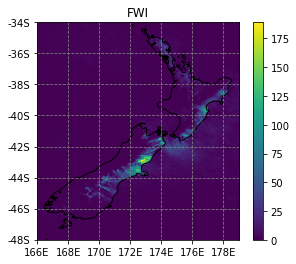

In [38]:
extreme_fwi_days = (fwi_data_5y >= 31).sum(axis=0) # days with at or over 31 in fwi rating
extreme_fwi_days.salem.quick_map()

## Due to fwi being based on wind temp and rain it shows fire risks above water. This is noticible at -42s, 175E. I will create a map removing this further down, but left this one as it is interesting

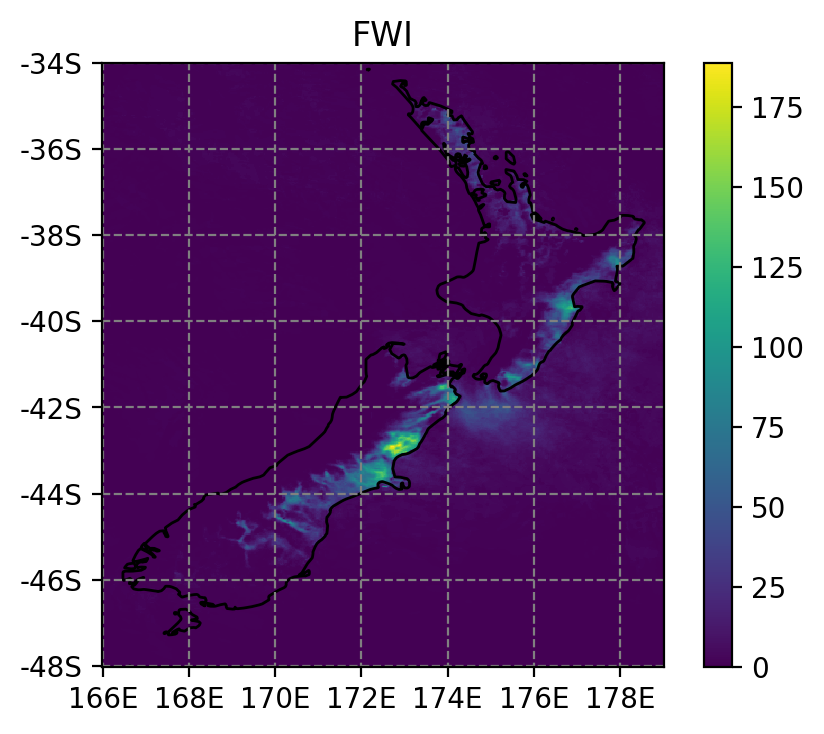

In [6]:
extreme_fwi_days = (fwi_data_5y >= 31).sum(axis=0) # days with at or over 31 in fwi rating
plt.figure(dpi=200)
extreme_fwi_days.salem.quick_map()

In [3]:
def mask_land(df):
    """creates a mask based on high soil moisture to mask non terestiral bodies"""
    smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'
    chunks={"height":1,"time":100}
    ds_s = xr.open_dataset(smois_file,chunks=chunks)
    cond_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
    mask=(ds_s.SMOIS[0,1,...]<0.9)
    return df.where(mask)

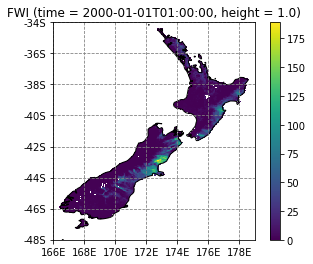

In [7]:
masked = mask_land(extreme_fwi_days)
masked.salem.quick_map()

### Map below has water bodies masked. The areas most at risk of fire are areas with high winds and lower rainfall along plans and east coast as expected

In [134]:
# masked = mask_land(extreme_fwi_days)
# plt.figure(dpi=200)
# #plt.title("Days with FWI over 31")
# masked.salem.quick_map()

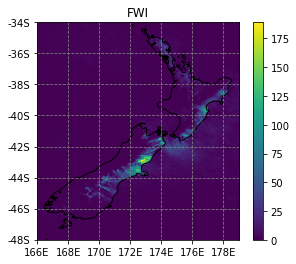

In [5]:
chunks={"time":24,"height":1}
fwi_data_5y = xr.open_mfdataset('fwi_5*',chunks=chunks).FWI
extreme_fwi_days = (fwi_data_5y >= 31).sum(axis=0) # days with at or over 31 in fwi rating
extreme_fwi_days.salem.quick_map()

Colour scheme below shows great variation but the highest fwi being green/blue is a bit missleading

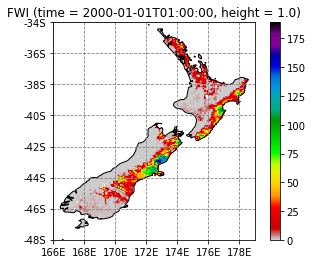

In [17]:
masked = mask_land(extreme_fwi_days)
# plt.figure(dpi=200)
var = masked.salem.quick_map(cmap='nipy_spectral_r')

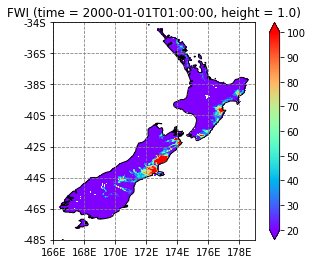

In [18]:
masked = mask_land(extreme_fwi_days)
masked.salem.quick_map(cmap='rainbow',vmin=20,vmax=100)

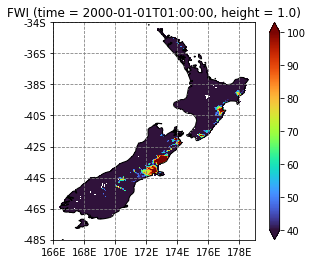

In [19]:
masked = mask_land(extreme_fwi_days)
masked.salem.quick_map(cmap='turbo',vmin=40,vmax=100)

The following two are better I left both as I could not decide on best

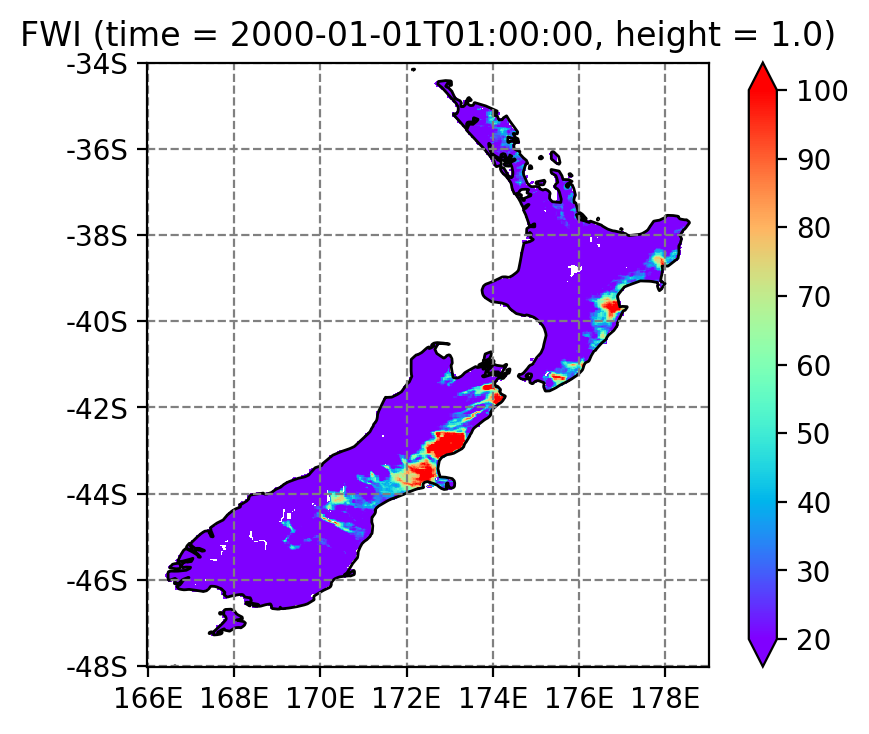

In [58]:
masked = mask_land(extreme_fwi_days)
plt.figure(dpi=200)
masked.salem.quick_map(cmap='rainbow',vmin=20,vmax=100)

## Exploring why these locations have high fwi
I expect the areas of high wind to have impacted the rate of fwi > 31 as the drying/spread risk wind poses will increase fwi
This is true along the plains and east of north island. It does not account for everything though. Further down I will explore the amouhnt of rain as lots of precipitation will lower the fire risk. Overlapping high wind and temp - low rain should explin alot of the high fwi areas

In [148]:
#ds_s = xr.open_mfdataset('/mnt/data/MetService_WRF/SMOIS_2016*',chunks=chunks)
!ls /mnt/data/MetService_WRF/S*   #Other years are missing :(

/mnt/data/MetService_WRF/SMOIS_20000101000000.nc


Windspeed years for comparision are wrong but theres only smois for this year avalible, hope thats okay i would have done 2016 or somewhere in the same timeline if possible

In [21]:
u_file='/mnt/data/MetService_WRF/U_20000101000000.nc'
v_file='/mnt/data/MetService_WRF/V_20000101000000.nc'
t_file = '/mnt/data/MetService_WRF/T_20000101000000.nc'
smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'

chunks={"height":1,"time":100}

def calculate_ws_wd(u,v):
    wspeed = xr.ufuncs.sqrt(u*u + v * v)
    wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
    wspeed.name = "wind speed"
    wdir.name = "wind dir"
    wspeed.attrs["units"] = "m/s"
    return wspeed, wdir

ds_u = xr.open_dataset(u_file,chunks=chunks)
ds_v = xr.open_dataset(v_file,chunks=chunks)
ds_t = xr.open_dataset(t_file,chunks=chunks)
ds_s = xr.open_dataset(smois_file,chunks=chunks)

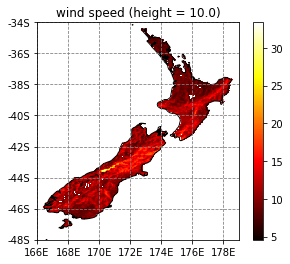

In [25]:
wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
land_only=wind.where(land_mask)
land_only_max_wind=land_only.isel(height=0).max(dim="time")
land_only_max_wind.salem.quick_map(cmap="hot")

## Map showing areas of high windspeed (over quartile 0.7)

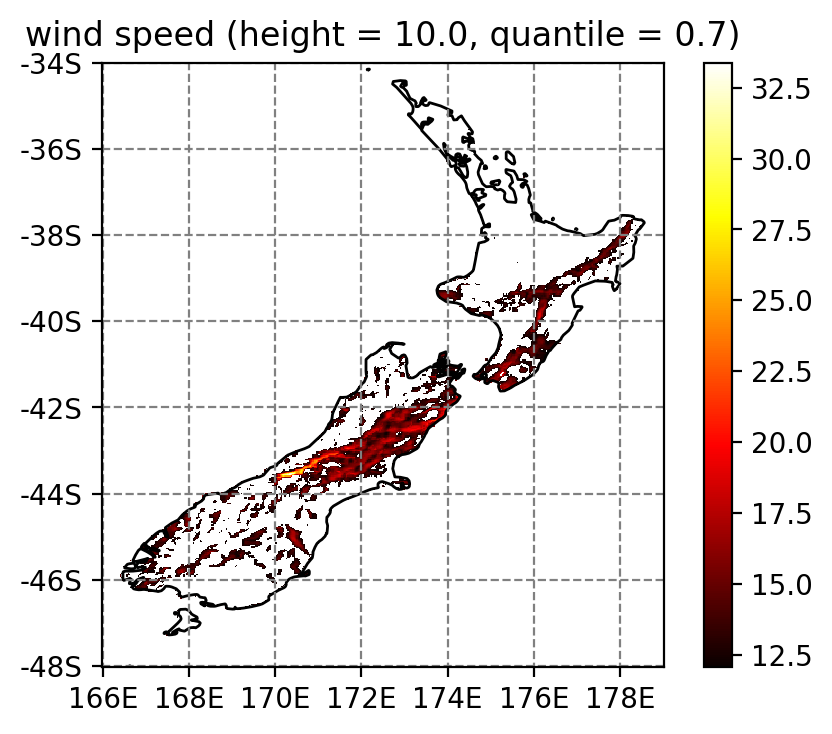

In [22]:
wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
plt.figure(dpi=200)
land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
land_only=wind.where(land_mask)
land_only_max_wind=land_only.isel(height=0).max(dim="time")
land_only_max_wind.where(land_only_max_wind>land_only_max_wind.quantile(0.7)).salem.quick_map(cmap="hot")

The high wind areas overlap high fwi areas as expected

For rain I have just done a single year for simplicitys sake

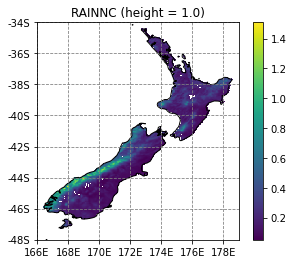

In [20]:
ds_rain = xr.open_mfdataset('/mnt/data/MetService_WRF/RAINNC_2016*',chunks=chunks)
land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
land_only_rain=ds_rain.where(land_mask)
land_only_avg_rain=land_only_rain.mean(dim="time")
land_only_avg_rain.RAINNC.salem.quick_map()

## Map showing areas of high average rainfall, Areas in white arevery low rainfall under 0.1 on arverage

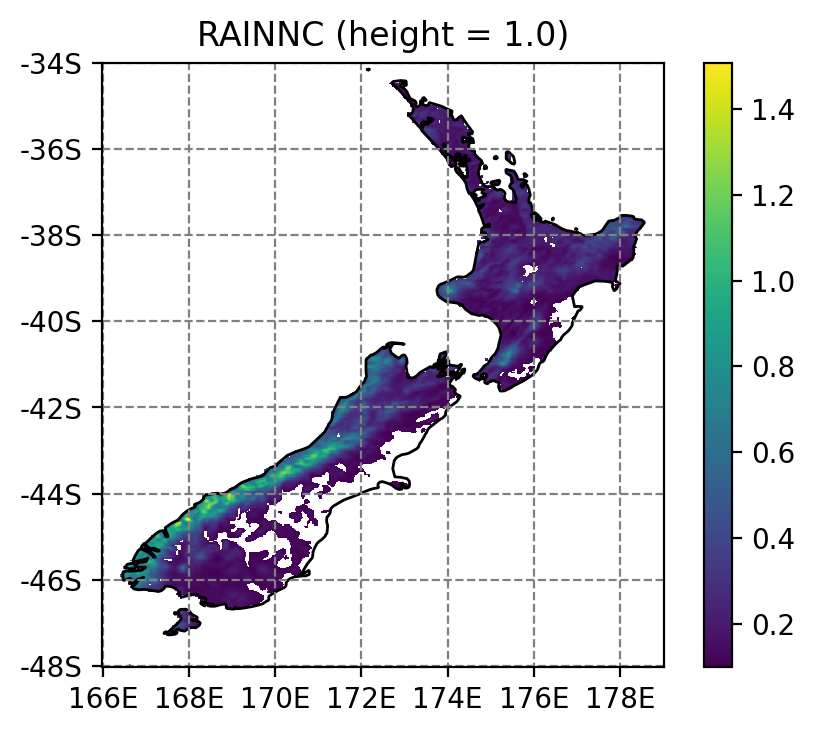

In [24]:
ds_rain = xr.open_mfdataset('/mnt/data/MetService_WRF/RAINNC_2016*',chunks=chunks)
plt.figure(dpi=200)
land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
land_only_rain=ds_rain.where(land_mask)
land_only_avg_rain=land_only_rain.mean(dim="time")
land_only_avg_rain.RAINNC.where(land_only_avg_rain.RAINNC>0.1).salem.quick_map()

In [12]:
# THIS WAS FAILING RAN OUT OF TIME TO FIX IT

# t_file = '/mnt/data/MetService_WRF/T_20000101000000.nc'   
# ds_t = xr.open_dataset(t_file,chunks=chunks)
# plt.figure(dpi=200)
# land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
# land_only_t=ds_t.where(land_mask)
# land_only_avg_t=land_only_t.mean(dim="time")
# land_only_avg_t.T.salem.quick_map()

# 2b) 
Over the last 20 years, is New Zealand experiencing a shift in fire weather to earlier
times in the season?
Hint: Use the extended spring-summer-autumn months from September to March (7
months) for these calculations. Use a minimum FWI threshold of 17. Aim to produce a
time series that aggregates all New Zealand pixels for a specific month of all the years.
You should end up with 7 time series plots (each represents a certain month).

In [2]:
# Grab data from pre prepared 20 year dataset
fwi_20_years = ds_u = xr.open_mfdataset("/mnt/data/FWI_WRF/FWI*",chunks={"time":72,"height":1},parallel=True)
fwi_20_years = xr.open_mfdataset("/mnt/data/FWI_WRF/FWI*",chunks={"time":72,"height":1},parallel=True)

In [3]:
#fwi_months_17 = fwi_20_years.FWI.where(fwi_20_years.FWI >= 17)

In [4]:
fwi_months = fwi_20_years.FWI.groupby("time").mean(...).resample(time='1M').mean()

In [5]:
# taking a look at chunks
fwi_months

<xarray.DataArray 'FWI' (time: 252)>
dask.array<stack, shape=(252,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31

## Plot below shows a trend over time where summers so plotting full 20 year fwi, 
## notice the general upward trend over time with peaks


Text(0.5, 1.0, 'FWI by month 2000-2020')

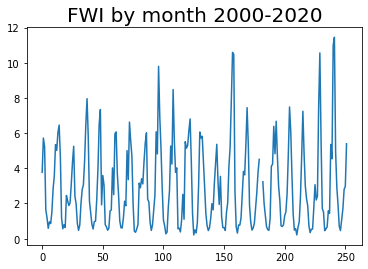

In [24]:
# Plot full 20 year fwi, notice the general upward trend over time
f, ax = plt.subplots()
fs = 20
plt.plot(fwi_months)
plt.title(label="FWI by month 2000-2020",fontsize=fs)

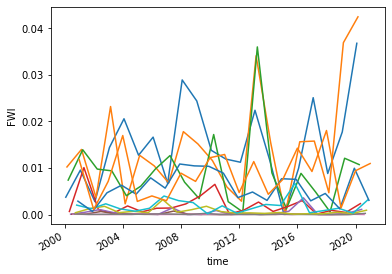

In [64]:
# Quick look at all the months to show it worked
for i in range(12):
    months[i+1].plot()

### Now with threshold of 17 applied

In [5]:
fwi_months_17 = fwi_20_years.FWI.where(fwi_20_years.FWI >= 17).groupby("time").mean(...).resample(time='1M').mean()

Text(0.5, 1.0, 'FWI by month 2000-2020 Thresholded over 17')

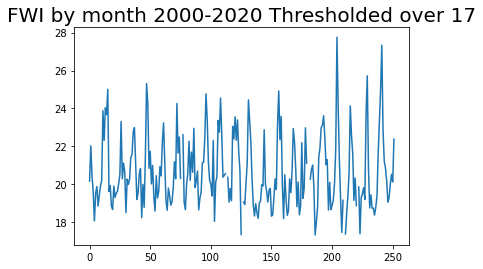

In [25]:
f, ax = plt.subplots()
fs = 20
plt.plot(fwi_months_17)
plt.title(label="FWI by month 2000-2020 Thresholded over 17",fontsize=fs)

In [8]:
# Group by each month
months = fwi_months.groupby('time.month')
months

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

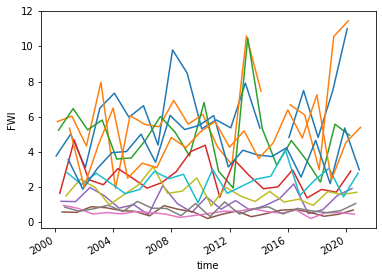

In [9]:
# Quick look at all the months to show it worked
for i in range(12):
    months[i+1].plot()

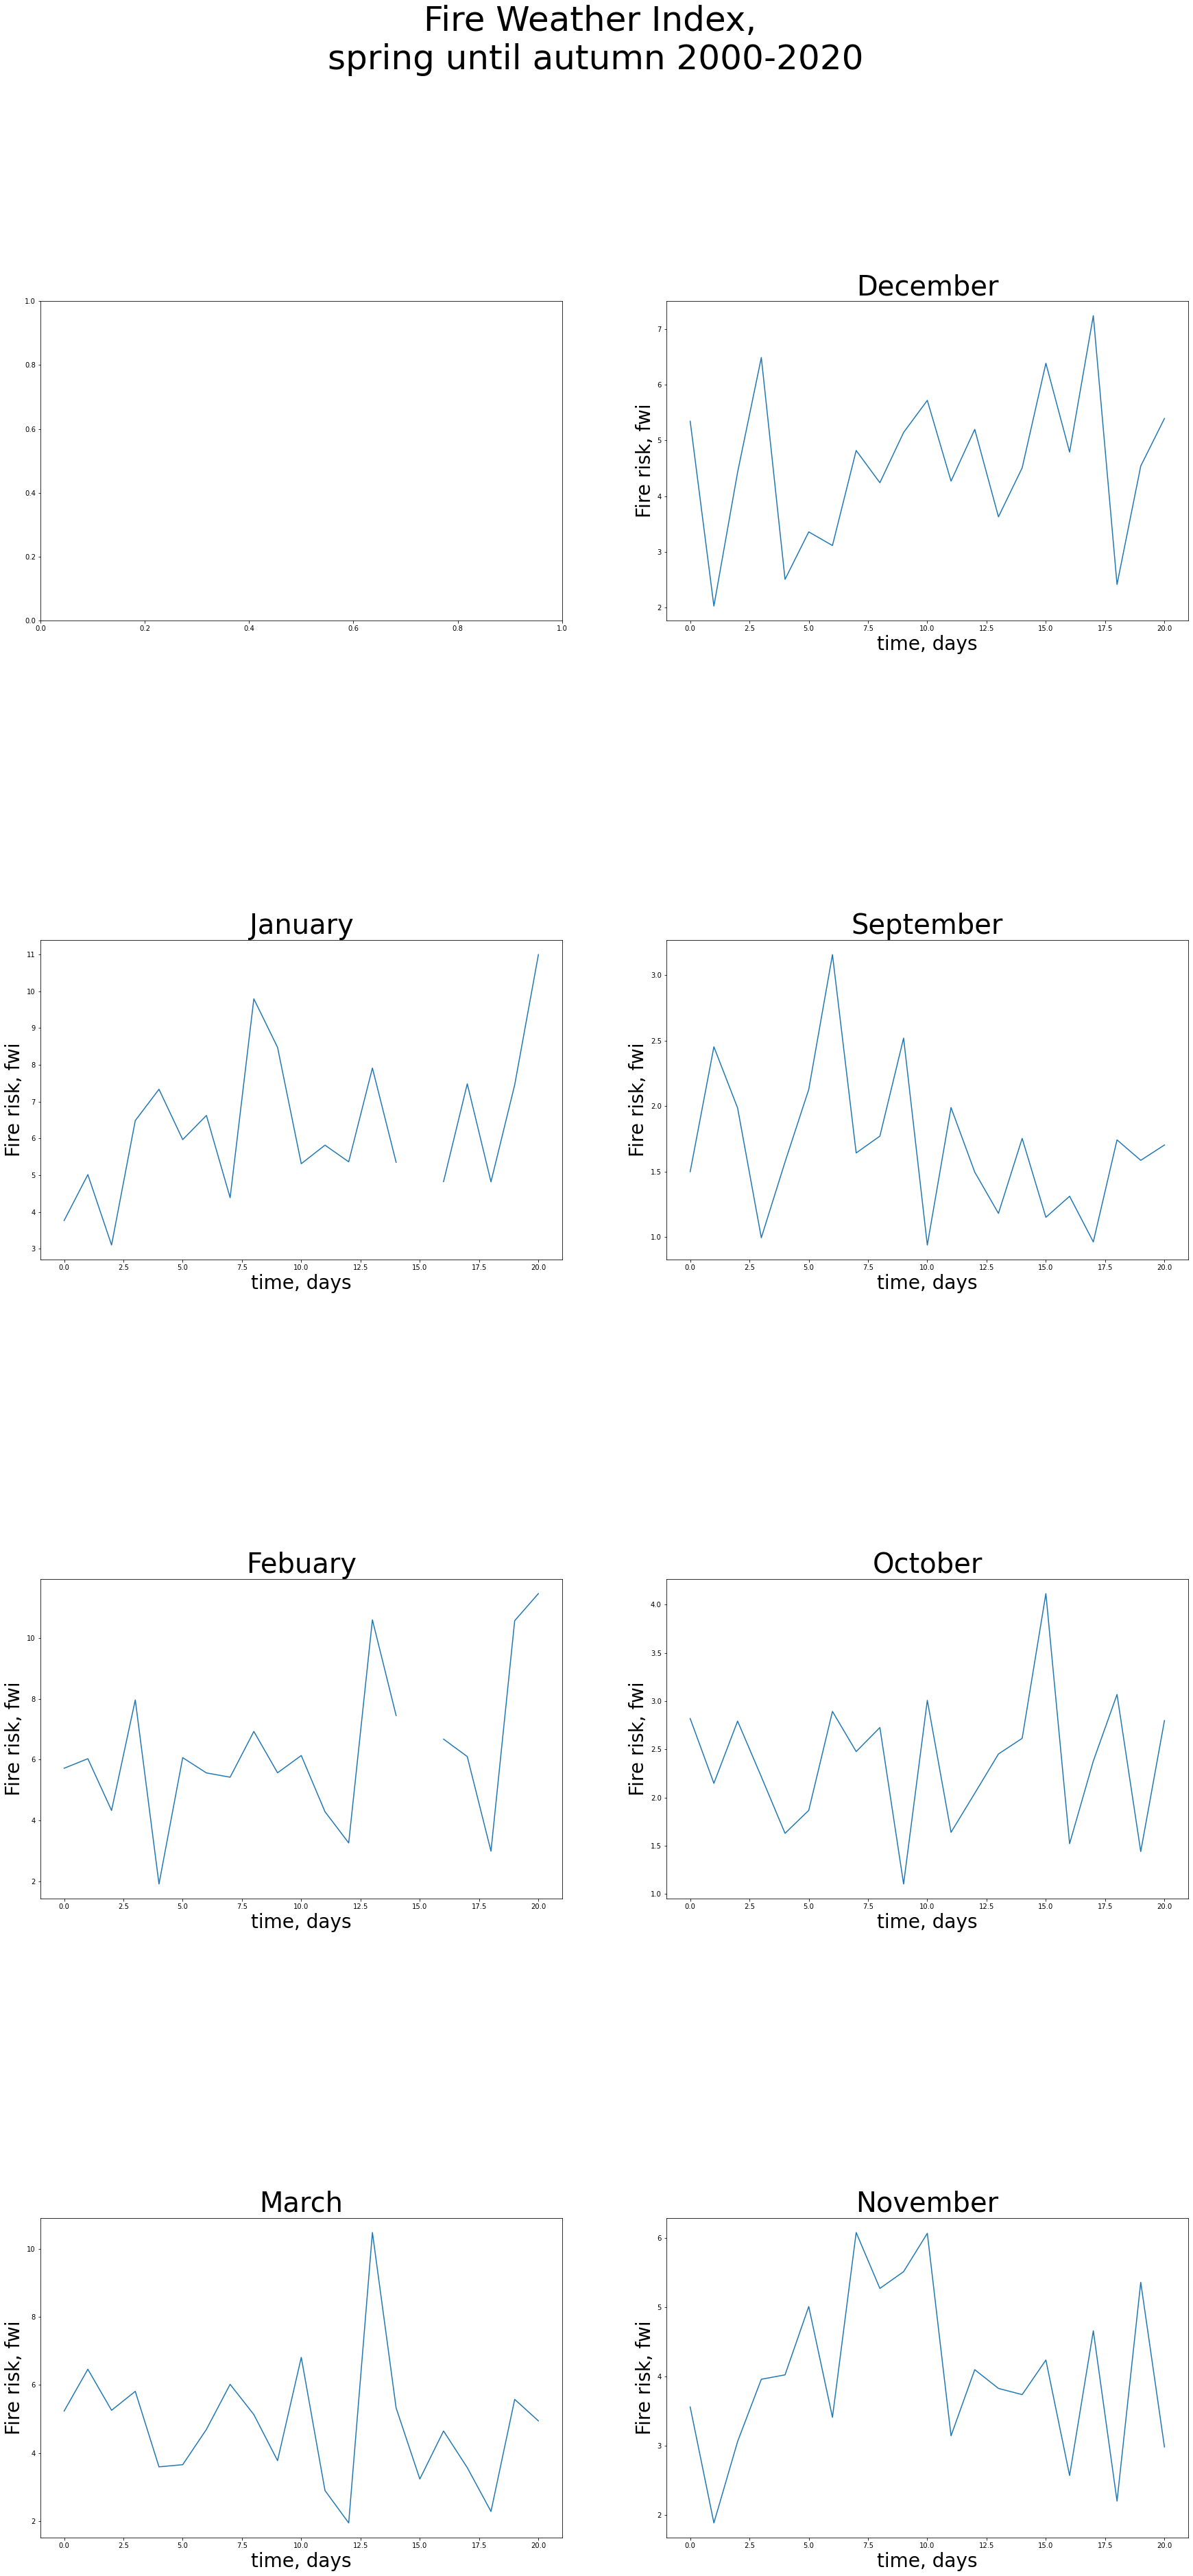

In [10]:
import numpy as np
import matplotlib.pyplot as plt

month_keys = {'September':9, 
          'October':10, 
          'November':11, 
          'December':12, 
          'January':1, 
          'Febuary':2, 
          'March':3}

month_list = ['September','October','November','December','January','Febuary','March']

fs = 40  # fontsize
fsa = 28  # fontsize axs
nrows, ncols = 4, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 60))

for row, month in enumerate(month_list):
    row = row + 1
    if row > 4:
        col = 0
    else:
        col = 1
        # plot with xarray
    if (row % 2 == 1):

        axs[row- 4, col].plot(months[month_keys[month]], )
        axs[row- 4, col].set_title(f'{month}', fontsize=fs)
        axs[row- 4, col].set_xlabel('time, days', fontsize=fsa)
        axs[row- 4, col].set_ylabel('Fire risk, fwi', fontsize=fsa)
    elif (row < 7):
        axs[row - 4, col].plot(months[month_keys[month]])
        axs[row - 4, col].set_title(f'{month}', fontsize=fs)
        axs[row - 4, col].set_xlabel('time, days', fontsize=fsa)
        axs[row - 4, col].set_ylabel('Fire risk, fwi', fontsize=fsa)

fig.suptitle("Fire Weather Index, \nspring until autumn 2000-2020",fontsize=50)
fig.subplots_adjust(hspace=1)
    
plt.show()

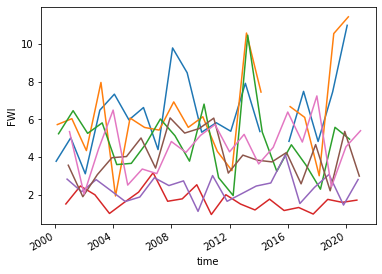

In [11]:
# 'September':9, 
# 'October':10, 
# 'November':11, 
# 'December':12, 
# 'January':1, 
# 'Febuary':2, 
# 'March':3

months[1].plot()
months[2].plot()
months[3].plot()
months[9].plot()
months[10].plot()
months[11].plot()
months[12].plot()

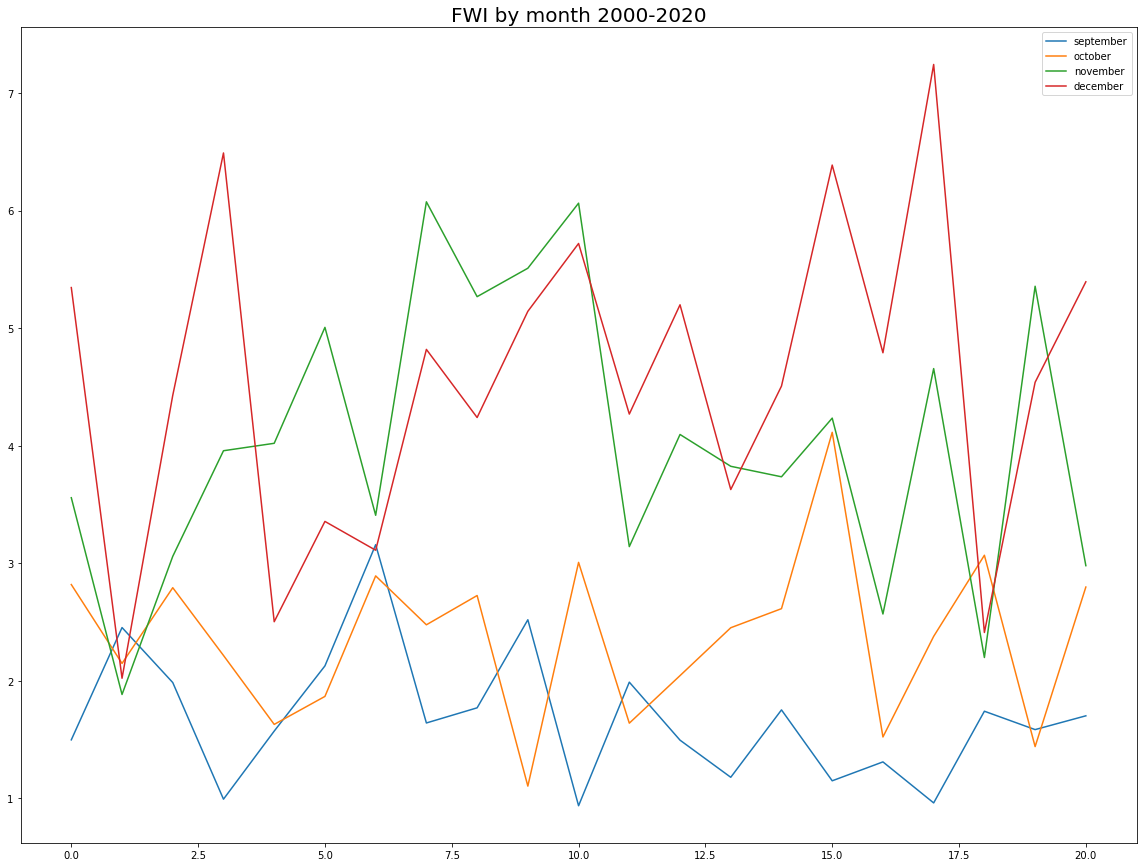

In [22]:
f, ax = plt.subplots(figsize=(20, 15))
fs = 20
plt.plot(months[9],label="september")
plt.plot(months[10],label="october")
plt.plot(months[11],label="november")
plt.plot(months[12],label="december")
plt.title(label="FWI by month 2000-2020",fontsize=fs)
plt.legend(loc="upper right")

I am really struggling to see a signal that indicats the peaks are getting earlier in the season. 

December ends up with some high peaks at the end i 2015 and 2017. But they are not much higher than 2003. 

November and october seem to range with no clear signal.

September seems to decrease over time.


.




I could see the peaks getting higher in the first plot in this section not splitting months. But I dont see how the threshold of min 17 fyi helps here? It made that harder to see